In [1]:
# study the muon veto efficiency in signal
# whether the signal clusters that fail muon veto are due to pileup or the other LLP

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import root_numpy
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
def keyToyear(key):
    for year in years:
        if year in key:
            return year

# Load ntuples

In [3]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]
# mass = [15]
# VBFH = 0
# decay = 'dddd'

# mass = [7, 15, 40, 55]
# VBFH=1
# decay = 'bbbb'



VBFH = 0
decay = 'dddd' #no vbfh generated
# decay = '4Tau'
decays = ['bbbb']

mass = [15, 40, 55]

ntupler_version = 'V1p17/'

analyzer_version = 'v1/v85/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Summer16/'+analyzer_version+'/normalized/'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'

# for m in mass:
#     for ct in ['100','1000','10000','100000']:
#         for d in decays:
#             key = 'MC_ggH_'+d+'_'+str(m)+'_'+str(ct)                       
#     #         fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'
#             if 'Summer16' in mc_path:
#                 fpath[key] = mc_path+'ggH_HToSSTo'+d+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCUETP8M1_13TeV-powheg-pythia8_35920pb_weighted.root'
#             elif 'MC_all' in mc_path:
#                 fpath[key] = mc_path+'ggH_HToSSTo'+d+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'
#             else:#fall17 and 18
#                 fpath[key] = mc_path+'ggH_HToSSTo'+d+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'


analyzer_version = 'v1/v100/'


mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
fpath['signal'] = mc_path+'ggH_HToSSTobbbb_MH-125.root'

analyzer_version = 'v1/v92/'

mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'


fpath['qcd'] = mc_path + 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_137000pb_weighted.root'
fpath['qcd'] = mc_path + 'QCD_HT700to1500_TuneCP5_13TeV-madgraphMLM-pythia8_137000pb_weighted.root'


analyzer_version = 'v5/v91/'
# analyzer_version = 'v5/v100/'
data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
# fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

# fpath['data18'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'


# data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2016/'+analyzer_version+'/normalized/'


# fpath['data16'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
# data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2017/'+analyzer_version+'/normalized/'

# fpath['data17'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'






# analyzer_version = 'v1/v48/'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
# for m in mass:
#     fpath[str(m)] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'.root'
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    print(k,v)
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    w = tree[k]["weight"].array()


signal /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all/v1/v100//normalized/ggH_HToSSTobbbb_MH-125.root
qcd /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v1/v92//normalized/QCD_HT700to1500_TuneCP5_13TeV-madgraphMLM-pythia8_137000pb_weighted.root
data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2018/v5/v91//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root


# nCsc with different hit vetoing

In [4]:
%%time



weight = {}

npv = {}
npu = {}
sel_ev = {}
cscRechitClusterJetVetoPt = {}
cscRechitClusterMuonVetoPt = {}
cscRechitClusterMuonVetoType = {}
cscRechitClusterNStation ={}
cscRechitClusterNStation5 ={}
cscRechitClusterNStation10 ={}
cscRechitClusterAvgStation5 = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterGenMuonVetoLLPIndex = {}
cscRechitClusterGenMuonVetoLLPDist = {}
cscRechitClusterGenMuonVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_index = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_r = {}
gLLP_decay_vertex_z_other = {}
gLLP_decay_vertex_r_other = {}
cluster_index = '3'
nJets = {}
gLLP_daughter_pt0 = {}
gLLP_daughter_pt1 = {}
gLLP_deltaR = {}
gLLP_pt = {}
gLLP_e = {}
cscRechitClusterSize = {}
cscRechitClusterMaxStation = {}
cscRechitClusterMaxChamber = {}
cscRechitClusterJetVetoNeutralFraction = {}
nMe1112 = {}
cscRechitClusterJetVetoElectronFraction = {}
cscRechitClusterJetVetoPhotonFraction = {}
cscRechitClusterJetVetoChargedHadronFraction = {}
cscRechitClusterJetVetoNeutralHadronFraction = {}
cscRechitClusterJetVetoMuonFraction = {}
cscRechitClusterMuonVetoLooseId = {}
cscRechitClusterMuonVetoTightId = {}
for k, T in tree.items():
#     if 'data' in k:continue
#     if 'MC' in k:continue
#     if not '40' in k:continue
########### SELECTION: CLUSTERS ############
    
    sel_rechitcluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) <= 2)

    if 'qcd' in k or 'data' in k:sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')>20)
    else:
    
        me1112_veto = 0
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < 10)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))


    print(np.count_nonzero(sel_rechitcluster.flatten()))

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############

    
    sel_ev[k]  = T.array('category') == 0
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)


    if 'data' in k or 'signa' in k:
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('METNoMuTrigger'))

    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    if 'signal' in k: 
        sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)

    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))
########### BRANCHES ############

    cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterGenMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'GenMuonVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterGenMuonVetoLLPIndex[k] = T.array('cscRechitCluster' + cluster_index + 'GenMuonVetoLLPIndex')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterGenMuonVetoLLPDist[k] = T.array('cscRechitCluster' + cluster_index + 'GenMuonVetoLLPDist')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    nMe1112[k] = (T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') +\
    T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') +\
    T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')+\
    T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()


    cscRechitClusterMuonVetoType[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoType')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     if k == 'data':
#         cscRechitClusterMuonVetoLooseId[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoLooseId')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#         cscRechitClusterMuonVetoTightId[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoTightId')[sel_rechitcluster][sel_ev[k]][:,0].flatten()


    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))



    cscRechitClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation[k] = T.array('cscRechitCluster' + cluster_index + 'NStation')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation5[k] = T.array('cscRechitCluster' + cluster_index + 'NStation5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation5[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterMaxStation[k] = T.array('cscRechitCluster' + cluster_index + 'MaxStation')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterMaxChamber[k] = T.array('cscRechitCluster' + cluster_index + 'MaxChamber')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))


    if 'qcd' in k or 'data' in k:
        cscRechitClusterJetVetoElectronFraction[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoElectronEnergyFraction')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterJetVetoPhotonFraction[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPhotonEnergyFraction')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterJetVetoChargedHadronFraction[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoChargedHadronEnergyFraction')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterJetVetoNeutralHadronFraction[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoNeutralHadronEnergyFraction')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterJetVetoMuonFraction[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoMuonEnergyFraction')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        cscRechitClusterJetVetoNeutralFraction[k] =cscRechitClusterJetVetoPhotonFraction[k]+cscRechitClusterJetVetoNeutralHadronFraction[k]


    cscRechitClusterSize[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))



    weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight'))[sel_ev[k]]
    npu[k] = T.array('npu')[sel_ev[k]]
    npv[k] = T.array('npv')[sel_ev[k]]
    sel_jet = np.logical_and(np.abs(T.array('jetEta')) <=2.0, np.abs(T.array('jetEta')) >0.8)
    nJets[k] = (sel_jet.sum())[sel_ev[k]]
    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))


#     if not 'qcd' in k and not 'data' in k:
#         cscRechitCluster_index[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_index')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     #     gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[sel_ev[k]]
#         gLLP_e[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_e')[sel_rechitcluster][sel_ev[k]][:,0].flatten()


#         gLLP_decay_vertex_r[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#         gLLP_decay_vertex_z[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#         gLLP_decay_vertex_r_other[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_other_decay_r')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#         gLLP_decay_vertex_z_other[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_other_decay_z')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     #     gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[1-cscRechitCluster_index[k]]][0]
#     #     gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     #     gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[sel_rechitcluster][sel_ev[k]][:,0].flatten()



#         gLLP_deltaR[k] = (T.array('gLLP_deltaR'))[sel_ev[k]]
#         gLLP_daughter_pt0[k] = T.array('gLLP_daughter_pt')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[(1-cscRechitCluster_index[k])*2]][0]
#         gLLP_daughter_pt1[k] = T.array('gLLP_daughter_pt')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[(1-cscRechitCluster_index[k])*2+1]][0]
#         gLLP_pt[k] = T.array('gLLP_pt')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[(1-cscRechitCluster_index[k])]][0]
#         gLLP_deltaR[k] = (T.array('gLLP_deltaR'))[sel_ev[k]]




            

16276
signal 49307 14464
signal 49307 14464
signal 49307 14464
signal 49307 14464
signal 49307 14464
1907237
qcd 4457078 1855256
qcd 4457078 1855256
qcd 4457078 1855256
qcd 4457078 1855256
qcd 4457078 1855256
379358
data 1048070 309676
data 1048070 309676
data 1048070 309676
data 1048070 309676
data 1048070 309676
CPU times: user 33.7 s, sys: 3.08 s, total: 36.8 s
Wall time: 1min 35s


In [7]:
for k in tree.keys():
    if not k == 'data':continue
    print(k, len(cscRechitClusterGenMuonVetoPt[k]))
    print(np.count_nonzero(cscRechitClusterGenMuonVetoPt[k]>0)/len(cscRechitClusterGenMuonVetoPt[k]))
    print(np.count_nonzero(cscRechitClusterMuonVetoPt[k]>20)/len(cscRechitClusterGenMuonVetoPt[k]))
    print(np.count_nonzero(cscRechitClusterMuonVetoLooseId[k])/len(cscRechitClusterGenMuonVetoPt[k]))
    print(np.count_nonzero(cscRechitClusterMuonVetoTightId[k])/len(cscRechitClusterGenMuonVetoPt[k]))

    print(np.count_nonzero(cscRechitClusterJetVetoPt[k]>20)/len(cscRechitClusterGenMuonVetoPt[k]))




#     print(np.mean(cscRechitClusterJetVetoNeutralHadronFraction[k]))
#     print(np.mean(cscRechitClusterJetVetoChargedHadronFraction[k]))
#     print(np.mean(cscRechitClusterJetVetoMuonFraction[k]))





data 309676
0.0
0.5835292370090029


KeyError: 'data'

In [10]:
k='data'
for nf in [0.8, 0.85, 0.9, 0.95]:
    print(np.count_nonzero(cscRechitClusterJetVetoNeutralFraction[k]>0.99)/np.count_nonzero(cscRechitClusterJetVetoNeutralFraction[k]>nf))

0.008110300081103
0.013981125480601188
0.029069767441860465
0.09433962264150944


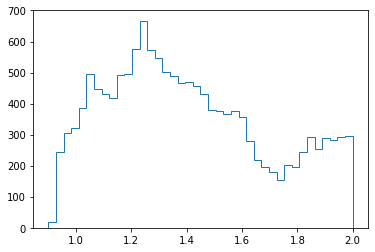

In [8]:
plt.hist(np.abs(cscRechitClusterEta['signal']),bins = 40,range=[0.9,2], histtype='step')

from tempfile import TemporaryFile
# outfile = TemporaryFile('/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/signalEta.root')
np.save('/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/signalEta', cscRechitClusterEta['signal'])


In [3]:
style = tdrstyle.setTDRStyle()



NameError: name 'tdrstyle' is not defined

# jet veto efficiency

qcd0.5 0.5353020267525573
data0.5 0.42858408864430614
qcd0.6 0.5728393668944927
data0.6 0.4703495136445149
qcd0.7 0.6233074683202061
data0.7 0.5132189332032238
qcd0.8 0.6548775728926397
data0.8 0.5656496831321326
qcd0.85 0.6855375673288617
data0.85 0.6072724496460026
qcd0.9 0.6740088311274455
data0.9 0.6361105079929522
qcd0.95 0.7150489077673915
data0.95 0.6726307914957944
qcd0.96 0.6919915412614387
data0.96 0.6638769506804697
qcd0.97 0.6053756931256907
data0.97 0.6758709927020209
qcd0.98 0.5834378211077171
data0.98 0.6670101637492942
qcd0.99 0.6065015679119541
data0.99 0.6323879551820728

****************************************
Minimizer is Linear
Chi2                      =      278.749
NDf                       =            9
p0                        =     0.607483   +/-   0.00237413  

****************************************
Minimizer is Linear
Chi2                      =      320.017
NDf                       =            9
p0                        =     0.509926   +/-   0.001

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1

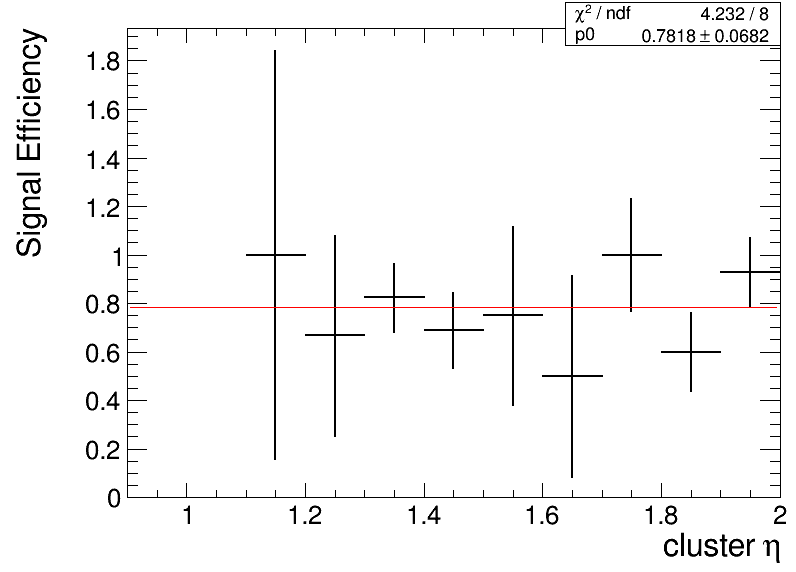

In [34]:
import numpy.ma as ma
import ROOT as rt
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff



pEff = {}
pEff1 = {}

c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.15,0.4,0.3)
leg = rt.TLegend(0.6,0.15,0.9,0.3)


leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npv, gLLP_decay_vertex_r, gLLP_decay_vertex_z, gLLP_deltaR, cscRechitClusterJetVetoPt,gLLP_e,gLLP_daughter_pt1,cscRechitClusterNStation10, cscRechitClusterSize,cscRechitClusterAvgStation10,cscRechitClusterMuonVetoType]
name = ['cscRechitClusterEta', 'npv', 'gLLP_decay_vertex_r', 'gLLP_decay_vertex_z', 'gLLP_deltaR', 'cscRechitClusterJetVetoPt','gLLP_e','gLLP_daughter_pt1','cscRechitClusterNStation10', 'cscRechitClusterSize','cscRechitClusterAvgStation10','cscRechitClusterMuonVetoType']

xaxis = ['cluster #eta', 'npv', 'LLP decay radius [cm] ', 'LLP decay Z [cm]',"#Delta R between LLPs",'jet p_{T} [GeV]','gLLP_e','gLLP_daughter_pt1','N_{stations}','cscRechitClusterSize','Avg Station Number','cscRechitClusterMuonVetoType']
bins = [[0.9,  1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0],[25,0,200],[20,0,700],[25,600,1200], [15,0,3],[50,0,2000],[25,0,300],[20,0,500],[5,0,5],[0,50,100,200,300,500,1000,2000],[1.0,1.25,1.5,1.75, 2,2.25, 2.5, 3,4],[10,0,10]]

# bins = [[0.9,  1.1,1.2,1.4,1.6,1.8,2.0],[25,0,200],[20,0,700],[25,600,1200], [15,0,3],[50,0,2000],[25,0,300],[20,0,500],[5,0,5],[0,50,100,200,300,500,1000,2000],[1.0,1.25,1.5,1.75, 2,2.25, 2.5, 3,4],[10,0,10]]


j = 0
reweight = 1
reweight_index = 5
reweight_target = 'data'
hist = {}
for nf in [0.5, 0.6,0.7,0.8, 0.85, 0.9, 0.95,0.96,0.97,0.98,0.99]:
    i = 0
#     if not nf == 0.95:continue
    c = rt.TCanvas('c','c', 800, 600)


    for k in cscRechitClusterEta.keys():
    #     if   not(k == 'MC_ggH_40_100' or k == 'MC_ggH_15_100' or k == 'MC_ggH_55_100') :continue
    #     if (not '40' in k) and not 'qcd' in k:continue
    #     if not '100000' in k:continue
        if not 'qcd' in k and not 'data' in k:continue
    #     if  k == 'qcd':continue
    #     if k == 'data':continue
        if k[-6:] == '40_100':continue
    #     if  k =='15':continue
    #     cond = cscRechitClusterJetVetoPt[k]<10
#         cond = np.logical_and(cscRechitClusterGenMuonVetoPt[k]==0, cscRechitClusterMuonVetoPt[k]<20)
        cond_b = np.logical_and(cscRechitClusterJetVetoNeutralFraction[k]>nf, cscRechitClusterJetVetoNeutralFraction[k] < 1.99)


        cond_b = np.logical_and(cond_b, cscRechitClusterGenMuonVetoPt[k] == 0)
        
#         print(k, np.count_nonzero(cond_b))
        cond = np.logical_and(cond_b, cscRechitClusterMuonVetoPt[k]<20)


        if reweight and (k == 'qcd' or 'data' in k):
            h_reweight = {}
            if k == 'qcd':h_reweight['qcd'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=['', ''], name=k, binning=bins[reweight_index],weights=weight[k])
            else:h_reweight['qcd'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=['', ''], name=k, binning=bins[reweight_index])
            h_reweight['data18'] = create_TH1D( np.abs(var[reweight_index][reweight_target]), axis_title=['', ''], name='data', binning=bins[reweight_index])
            h_reweight['qcd'].Scale(1./h_reweight['qcd'].Integral())
            h_reweight['data18'].Scale(1./h_reweight['data18'].Integral())
            h_reweight['data18'].Divide(h_reweight['qcd'])
            weight_temp = []
            a = root_numpy.hist2array(h_reweight['data18'], return_edges=True)
            edge = a[1][0]
            values = a[0]
#             print(k, edge, values)
            weight_temp = values[np.argmax(edge>var[reweight_index][k][:,None],axis=1)-1]
    #         for m in range(len(var[reweight_index][k])):
    #             weight_temp.append(h_reweight['data18'].GetBinContent(h_reweight['data18'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            weight_temp = np.array(weight_temp)
        else:weight_temp = np.ones((len(var[j][k]),))
        total_weight = weight_temp*weight[k]
        if 'data' in k: total_weight = total_weight*0.0+1
#         print(np.sum(total_weight), np.count_nonzero(cond_b))
        hm = create_TH1D(np.abs(var[j][k][cond&cond_b]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = total_weight[cond&cond_b])
        hb = create_TH1D(np.abs(var[j][k][cond_b]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = total_weight[cond_b])
        pEff[k+str(nf)] = rt.TEfficiency(hm,hb)
        pEff[k+str(nf)].SetLineColor(std_color_list[1-i])
        pEff[k+str(nf)].SetLineWidth(2)
        pEff[k+str(nf)].Draw('' if i == 0 else 'same')
        avg = 0.0
        hist[k+str(nf)] = hm.Clone()
        for m in range(len(bins[j])):
            avg += pEff[k+str(nf)].GetEfficiency(m+1)
            hist[k+str(nf)].SetBinContent(m+1,pEff[k+str(nf)].GetEfficiency(m+1) )
            hist[k+str(nf)].SetBinError(m+1,pEff[k+str(nf)].GetEfficiencyErrorLow(m+1) )

#         print(k+str(nf), avg/len(bins[j]))
        
        hist[k+str(nf)].Fit('pol0')
        hist[k+str(nf)].Draw('' if i == 0 else 'same')


#         f = rt.TBinomialEfficiencyFitter(
#                                  hm, hb);
#         f.Fit(eff, "I");
        avg = 0.0
        for m in range(len(bins[j])):
            avg += pEff[k+str(nf)].GetEfficiency(m+1)
        print(k+str(nf), avg/len(bins[j]))
#         leg.AddEntry(pEff[k+nf],k)

#         hm = create_TH1D(np.ones(len( total_weight[cond&cond_b])), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=[1,0,2], weights = total_weight[cond&cond_b])
#         hb = create_TH1D(np.ones(len( total_weight[cond_b])), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=[1,0,2], weights = total_weight[cond_b])
#         pEff1[k]= rt.TEfficiency(hm,hb)
#         print(k, pEff1[k].GetEfficiency(1), pEff1[k].GetEfficiencyErrorLow(1), pEff1[k].GetEfficiencyErrorUp(1))

        i+=1
#     c = make_ratio_pEff([pEff['qcd'+str(nf)],pEff['data'+str(nf)]], fit = False, logy=False, in_tags = ["QCD","Data"], ratio_bounds = [0.0,3], draw_opt = ['E2','E1']) 
    c.Draw()

#     c.SaveAs("../../plots/MuonSystem_Analysis/muonVeto/"+name[j]+"neutralFraction"+str(nf).replace(".", "p")+".png")
#     c.SaveAs("../../plots/MuonSystem_Analysis/muonVeto/"+name[j]+"neutralFraction"+str(nf).replace(".", "p")+".C")





In [37]:
nom = {}
nom_unc = {}
k_target = 'signal'
h_eta = create_TH1D(np.abs(cscRechitClusterEta[k_target]), 'hb1', binning=bins[0], weights = weight[k_target])
denom_unc = np.sum(weight[k_target]**2)**0.5 #absolute uncertainty of denominator
print("denominator uncertainty:", denom_unc/h_eta.Integral())

nf = 0.8

for k in ['qcd', 'data']:
    nom[k] = 0
    nom_unc[k] = 0
    for i in range(h_eta.GetNbinsX()):
#         if k == 'data' or i <= 1:print(k,nf, i, pEff[k+str(nf)].GetEfficiency(i+1),pEff[k+str(nf)].GetEfficiencyErrorLow(i+1),pEff[k+str(nf)].GetEfficiencyErrorUp(i+1))
#         else:print(k,'0.95', i, pEff['qcd0.95'].GetEfficiency(i+1),pEff['qcd0.95'].GetEfficiencyErrorLow(i+1),pEff['qcd0.95'].GetEfficiencyErrorUp(i+1))
        
        if i <= 1 and 'qcd' in k:
            sf = pEff[k+str(nf)].GetEfficiency(i+1)/pEff['data'+str(nf)].GetEfficiency(i+1)
            sf_unc = ((pEff[k+str(nf)].GetEfficiencyErrorLow(i+1)/pEff[k+str(nf)].GetEfficiency(i+1))**2 + (pEff['data'+str(nf)].GetEfficiencyErrorLow(i+1)/pEff['data'+str(nf)].GetEfficiency(i+1))**2)**0.5*sf
        else:
            sf = pEff[k+'0.95'].GetEfficiency(i+1)/pEff['data0.95'].GetEfficiency(i+1)
            sf_unc = ((pEff[k+'0.95'].GetEfficiencyErrorLow(i+1)/pEff[k+'0.95'].GetEfficiency(i+1))**2 + (pEff['data0.95'].GetEfficiencyErrorLow(i+1)/pEff['data0.95'].GetEfficiency(i+1))**2)**0.5*sf


        nom[k] += h_eta.GetBinContent(i+1)*pEff['data0.95'].GetEfficiency(i+1)*sf
        nom[k] += h_eta.GetBinContent(i+1)*sf


        print(k,pEff['data0.95'].GetEfficiency(i+1), sf)
        if h_eta.GetBinContent(i+1)*pEff['data0.95'].GetEfficiency(i+1)*sf>0:            
            if k == 'data':nom_unc[k]+=(((h_eta.GetBinError(i+1)/h_eta.GetBinContent(i+1))**2 + (pEff['data0.95'].GetEfficiencyErrorLow(i+1)/\
                                                                                  pEff['data0.95'].GetEfficiency(i+1))**2)**0.5*h_eta.GetBinContent(i+1)*pEff['data0.95'].GetEfficiency(i+1))**2
            else:nom_unc[k]+=(((h_eta.GetBinError(i+1)/h_eta.GetBinContent(i+1))**2 + (sf_unc/sf)**2)**0.5*h_eta.GetBinContent(i+1)*sf)**2
#             nom_unc[k] += (h_eta.GetBinContent(i+1)*pEff[pEff_key].GetEfficiencyErrorLow(i+1))**2
       

    nom_unc[k] = nom_unc[k]**0.5 ##absolute uncertainty
    print(nom_unc[k]/nom[k])
    eff = nom[k]/h_eta.Integral()
    eff_unc = ((nom_unc[k]/nom[k])**2+(denom_unc/h_eta.Integral())**2)**0.5*eff # absolute uncertainty on efficiency
    print(k, nom[k]/h_eta.Integral(), eff_unc)

print(nom['data']/nom['qcd'])


denominator uncertainty: 0.008883728011099244
qcd 0.7142857142857143 1.2083498003390631
qcd 0.75 0.9431242144128265
qcd 0.7450980392156863 0.8798962770427475
qcd 0.8473684210526315 1.0032631106252305
qcd 0.7467248908296943 1.137977925884387
qcd 0.6875 1.2674261045872826
qcd 0.6521739130434783 1.1517248406450014
qcd 0.7313432835820896 1.2753447927537773
qcd 0.7444444444444445 1.1425915103620925
qcd 0.78 1.0829892307018494
0.08542763443462682
qcd 0.8059770727166438 0.06922400658087809
data 0.7142857142857143 1.0
data 0.75 1.0
data 0.7450980392156863 1.0
data 0.8473684210526315 1.0
data 0.7467248908296943 1.0
data 0.6875 1.0
data 0.6521739130434783 1.0
data 0.7313432835820896 1.0
data 0.7444444444444445 1.0
data 0.78 1.0
0.08241749903734465
data 0.7439845456350003 0.06167252597011413
0.9230840067538273


Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).


# plot ratio vs. neutral fraction

In [20]:
import numpy.ma as ma
import ROOT as rt
pEff = {}
pEff1 = {}

c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.15,0.4,0.3)
leg = rt.TLegend(0.6,0.15,0.9,0.3)


leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npv, gLLP_decay_vertex_r, gLLP_decay_vertex_z, gLLP_deltaR, cscRechitClusterJetVetoPt,gLLP_e,gLLP_daughter_pt1,cscRechitClusterNStation10, cscRechitClusterSize,cscRechitClusterAvgStation10,cscRechitClusterMuonVetoType]
name = ['cscRechitClusterEta', 'npv', 'gLLP_decay_vertex_r', 'gLLP_decay_vertex_z', 'gLLP_deltaR', 'cscRechitClusterJetVetoPt','gLLP_e','gLLP_daughter_pt1','cscRechitClusterNStation10', 'cscRechitClusterSize','cscRechitClusterAvgStation10','cscRechitClusterMuonVetoType']

xaxis = ['cluster #eta', 'npv', 'LLP decay radius [cm] ', 'LLP decay Z [cm]',"#Delta R between LLPs",'jet p_{T} [GeV]','gLLP_e','gLLP_daughter_pt1','N_{stations}','cscRechitClusterSize','Avg Station Number','cscRechitClusterMuonVetoType']
bins = [[0.9, 1.0, 1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0],[25,0,200],[20,0,700],[25,600,1200], [15,0,3],[50,0,2000],[25,0,300],[20,0,500],[5,0,5],[0,50,100,200,300,500,1000,2000],[1.0,1.25,1.5,1.75, 2,2.25, 2.5, 3,4],[10,0,10]]


j = 0
i = 0
reweight = 1
reweight_index = 5
reweight_target = 'data'

for k in cscRechitClusterEta.keys():

    if not 'qcd' in k and not 'data' in k:continue
    if k[-6:] == '40_100':continue
    for nf in [0.8, 0.85, 0.9, 0.95]:
        cond = np.logical_and(cscRechitClusterGenMuonVetoPt[k]==0, cscRechitClusterMuonVetoPt[k]<20)

        cond_b = np.logical_and(cscRechitClusterJetVetoNeutralFraction[k]>nf, cscRechitClusterGenMuonVetoPt[k] == 0)
        print(k, np.count_nonzero(cond_b))
        cond = np.logical_and(cond_b, cscRechitClusterMuonVetoPt[k]<20)
        if reweight and (k == 'qcd' or 'data' in k):
            h_reweight = {}
            if k == 'qcd':h_reweight['qcd'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=['', ''], name=k, binning=bins[reweight_index],weights=weight[k])
            else:h_reweight['qcd'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=['', ''], name=k, binning=bins[reweight_index])
            h_reweight['data18'] = create_TH1D( np.abs(var[reweight_index][reweight_target]), axis_title=['', ''], name='data', binning=bins[reweight_index])
            h_reweight['qcd'].Scale(1./h_reweight['qcd'].Integral())
            h_reweight['data18'].Scale(1./h_reweight['data18'].Integral())
            h_reweight['data18'].Divide(h_reweight['qcd'])
            weight_temp = []
            a = root_numpy.hist2array(h_reweight['data18'], return_edges=True)
            edge = a[1][0]
            values = a[0]
            print(k, edge, values)
            weight_temp = values[np.argmax(edge>var[reweight_index][k][:,None],axis=1)-1]
    #         for m in range(len(var[reweight_index][k])):
    #             weight_temp.append(h_reweight['data18'].GetBinContent(h_reweight['data18'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            weight_temp = np.array(weight_temp)
        else:weight_temp = np.ones((len(var[j][k]),))
        total_weight = weight_temp*weight[k]
        if 'data' in k: total_weight = total_weight*0.0+1
        print(np.sum(total_weight), np.count_nonzero(cond_b))
        hm = create_TH1D(np.abs(var[j][k][cond&cond_b]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = total_weight[cond&cond_b])
        hb = create_TH1D(np.abs(var[j][k][cond_b]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = total_weight[cond_b])
        pEff[k] = rt.TEfficiency(hm,hb)
        pEff[k].SetLineColor(std_color_list[1-i])
        pEff[k].SetLineWidth(2)
        pEff[k].Draw('' if i == 0 else 'same')
        leg.AddEntry(pEff[k],k)


        i+=1
    #     print(k,hm.Integral(),hb.Integral())
        pEff['data'].Divide(pEff['qcd'])
#     c = make_ratio_pEff([pEff['qcd'],pEff['data']], fit = False, logy=False, in_tags = ["QCD","Data"], ratio_bounds = [0.0,3], draw_opt = ['E2','E1']) 


    # leg.Draw()
    c.Draw()







qcd 39269
qcd [   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.  520.  560.  600.  640.  680.  720.  760.  800.  840.  880.  920.
  960. 1000. 1040. 1080. 1120. 1160. 1200. 1240. 1280. 1320. 1360. 1400.
 1440. 1480. 1520. 1560. 1600. 1640. 1680. 1720. 1760. 1800. 1840. 1880.
 1920. 1960. 2000.] [4.36468274e+00 4.50493150e+00 4.46082987e+00 3.25678744e+00
 2.25909767e+00 1.53718535e+00 9.65001729e-01 5.51574645e-01
 3.52391992e-01 3.03219279e-01 3.53523841e-01 4.11364704e-01
 5.24359607e-01 6.30590998e-01 7.61503733e-01 9.21996074e-01
 1.16030317e+00 1.64890931e+00 2.84727401e+00 6.23651397e+00
 1.68862751e+01 5.16759303e+01 1.43106451e+02 2.86684000e+02
 6.13913364e+02 4.08796994e+02 7.24790396e+04 0.00000000e+00
 5.50624044e+03 1.01815618e+03 1.17988280e+03 1.79378738e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.51685764e+01
 0.

KeyError: 'data'

Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


signal 14464
signal 1.0
signal


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


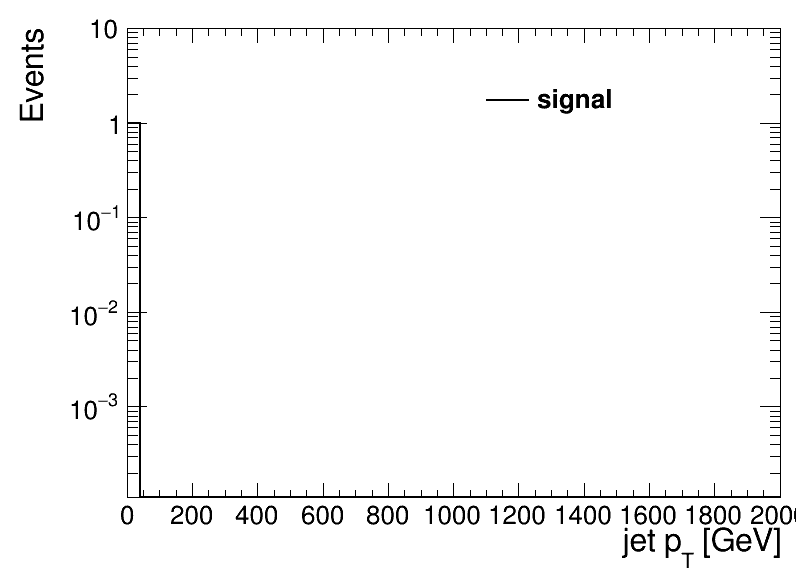

In [7]:
import numpy.ma as ma
import ROOT as rt
h = {}

c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.6,0.75,0.9,0.9)


leg.SetTextSize(0.05)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npv, gLLP_decay_vertex_r, gLLP_decay_vertex_z,gLLP_deltaR, cscRechitClusterJetVetoPt,gLLP_daughter_pt0,gLLP_daughter_pt1,gLLP_pt,cscRechitClusterGenMuonVetoPt,cscRechitClusterMuonVetoType, cscRechitClusterAvgStation10, cscRechitClusterNStation10, cscRechitClusterMaxStation, cscRechitClusterMaxChamber]
name = ['cscRechitClusterEta', 'npv', 'gLLP_decay_vertex_r', 'gLLP_decay_vertex_z','gLLP_deltaR', 'cscRechitClusterJetVetoPt','gLLP_daughter_pt0','gLLP_daughter_pt1','gLLP_pt','cscRechitClusterGenMuonVetoPt','cscRechitClusterMuonVetoType', 'cscRechitClusterAvgStation10', 'cscRechitClusterNStation10', 'cscRechitClusterMaxStation', 'cscRechitClusterMaxChamber']

xaxis = ['cluster #eta', 'npu', 'LLP decay radius [cm] ', 'LLP decay Z [cm]',"#Delta R between LLPs",'jet p_{T} [GeV]','gLLP_daughter_pt0','gLLP_daughter_pt1','gLLP_pt','cscRechitClusterGenMuonVetoPt','cscRechitClusterMuonVetoType','cscRechitClusterAvgStation10','cscRechitClusterNStation10','cscRechitClusterMaxStation','cscRechitClusterMaxChamber']
bins = [[0.9,1.0, 1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0],[50,0,200],[0,10,20,40,60,80,100,200,300,700],[0,20,40,60,80,100,200,300,500,800,1200], [20,0,5],[50,0,2000],[25,0,300],[50,0,500],[50,0,500],[50,0,100],[10,0,10],[1.0,1.25,1.5,1.75, 2,2.25, 2.5, 3,4],[5,0,5],[5,0,5],[50,0,50]]
j = 5
i = 0
reweight = 1
reweight_index = 5
for k in cscRechitClusterEta.keys():
#     if not i == 1:continue
#     if   not(k == 'MC_ggH_40_100' or k == 'MC_ggH_15_100' or k == 'MC_ggH_55_100') :continue
#     if not '40' in k:continue
    print(k,len(cscRechitClusterEta[k]))
#     if not 'qcd' in k and not 'data' in k and not :continue
#     print(gLLP_pt[k].shape,cscRechitClusterJetVetoPt[k].shape)
#     if not '15' in k:continue
#     if  k =='15':continue
#     cond = cscRechitClusterNStation5[k]==1
#     cond = cscRechitClusterMuonVetoPt[k]>=0
#     cond = np.abs(cscRechitClusterMaxChamber[k])>=0
#     cond = cscRechitClusterGenMuonVetoPt[k] == 0
#     if k == 'data':continue
    if not k == 'signal':cond = np.logical_and(cscRechitClusterJetVetoNeutralFraction[k]>0.95, cscRechitClusterGenMuonVetoPt[k] == 0)
    else: cond = np.abs(cscRechitClusterMaxChamber[k])>=0
#     cond_b = np.logical_or(gLLP_decay_vertex_r[k]>0, np.abs(gLLP_decay_vertex_z[k])>0)
#     cond_b = np.logical_and(gLLP_decay_vertex_r[k]<50, np.abs(gLLP_decay_vertex_z[k])<100)

    if reweight and k == 'qcd':
            h_reweight = {}
            h_reweight['qcd'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=['', ''], name=k, binning=bins[reweight_index],weights=weight[k])
            h_reweight['data'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=['', ''], name='data', binning=bins[reweight_index])
            h_reweight['data'].Divide(h_reweight['qcd'])
            weight_temp = []
            a = root_numpy.hist2array(h_reweight['data'], return_edges=True)
            edge = a[1][0]
            values = a[0]
            weight_temp = values[np.argmax(edge>var[reweight_index][k][:,None],axis=1)-1]
            weight_temp = np.array(weight_temp)
    else:weight_temp = np.ones((len(var[j][k]),))
        
        
        
        
    total_weight = weight_temp*weight[k]
    if 'data' in k:total_weight = total_weight*0.0+1
    h[k] = create_TH1D(np.abs(var[j][k][cond]), 'hb1', axis_title = [xaxis[j],'Events'], binning=bins[j], weights = total_weight[cond])


    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    print(k,h[k].Integral())
    h[k].SetLineWidth(2)
    h[k].SetMaximum(10)
    h[k].SetMinimum(0.00011)
    h[k].DrawNormalized('same hist')
    leg.AddEntry(h[k],k)
    i+=1
    print(k)
leg.Draw()
c.SetLogy()
c.Draw()




c.Update()


# c.SaveAs("../../plots/MuonSystem_Analysis/muonVeto/"+name[j]+"_denom.png")
# c.SaveAs("../../plots/MuonSystem_Analysis/muonVeto/"+name[j]+"_denom.C")




#         if r:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".C")
#         else:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".C")




